In [11]:
import stablerank.srank as sr
from ripser import ripser
import _pickle as pickle
import numpy as np
inf=float("inf")
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import scipy.spatial as spatial
from scipy.spatial.distance import cdist, pdist, squareform
import scipy.stats as st
from timeit import default_timer as timer
from datetime import timedelta
from sklearn import svm
from sklearn.metrics import accuracy_score
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets



# If an import fails, run the install lines below and re-run.
import os, json, math, warnings
import numpy as np
from pathlib import Path
from tqdm import tqdm
from joblib import Parallel, delayed

# ML
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report


In [ ]:

BASE_DIR     = '.'
META_PATH    = os.path.join(BASE_DIR, 'stft_np', 'meta.json')
np.set_printoptions(precision=4, suppress=True)

# How many clips per class to use for experiments
N_PER_CLASS  = 800         # bump up if compute allows
TEST_SIZE    = 0.2
RANDOM_STATE = 42

# Load memmaps
with open(META_PATH, 'r') as f:
    meta = json.load(f)

dtype_str = meta.get('dtype', 'float16')
if isinstance(dtype_str, str) and dtype_str.startswith("<class 'numpy."):
    dtype_str = dtype_str.split('.')[-1].split("'")[0]

A_mm = np.memmap(os.path.join(BASE_DIR, 'stft_np', meta['A_memmap']), dtype=dtype_str, mode='r', shape=tuple(meta['A_shape']))
B_mm = np.memmap(os.path.join(BASE_DIR, 'stft_np', meta['B_memmap']), dtype=dtype_str, mode='r', shape=tuple(meta['B_shape']))
print("A:", A_mm.shape, "B:", B_mm.shape)

# Labels
rng = np.random.default_rng(RANDOM_STATE)
nA, nB = A_mm.shape[0], B_mm.shape[0]
nA_use = min(N_PER_CLASS, nA)
nB_use = min(N_PER_CLASS, nB)
idxA = rng.choice(nA, size=nA_use, replace=False)
idxB = rng.choice(nB, size=nB_use, replace=False)
y   = np.concatenate([np.zeros(nA_use, dtype=int), np.ones(nB_use, dtype=int)])
A = [A_mm[i] for i in idxA]
B = [B_mm[i] for i in idxB]
data = A + B

A: (940, 1000, 257) B: (973, 1000, 257)


# playing around

In [ ]:
A_unpacked = [A_mm[i] for i in range(A_mm.shape[0])]
B_unpacked = [B_mm[i] for i in range(B_mm.shape[0])]



In [ ]:
# Fix: compute complete-linkage kernels over a finite interval to avoid +inf integrals
import numpy as np
from joblib import Parallel, delayed
from tqdm.auto import tqdm

try:
    t_grid = np.load("/Users/theodorbjork/SF2956 copy 2/stft_np/tda_features/t_grid.npy")
    T_DEFAULT = float(t_grid[-1])
except Exception:
    T_DEFAULT = None  # will fall back to pairwise min domain


def safe_dot(f, g, T=None):
    if T is None:
        T = T_DEFAULT
    if T is None:
        # fallback: integrate up to the min of the supports
        T = float(min(f.content[0][-1], g.content[0][-1]))
    return float(f.dot(g, interval=[0.0, T]))


def row_vs_list_safe(f, G, T=None):
    return np.fromiter((safe_dot(f, g, T=T) for g in G), dtype=float, count=len(G))

# Example recomputation (uncomment to run)
# n = len(train_h0sr_complete)
# rows = Parallel(n_jobs=-1, prefer="processes")(delayed(row_vs_list_safe)(train_h0sr_complete[i], train_h0sr_complete[i:], T=T_DEFAULT) for i in tqdm(range(n)))
# K = np.empty((n, n), float)
# for i, r in enumerate(rows):
#     K[i, i:] = r
#     K[i:, i] = r
# h0_complete_kernel_train = K
# print("finite %:", 100*np.isfinite(h0_complete_kernel_train).mean())


In [ ]:
import numpy as np
from time import perf_counter
from math import ceil
from tqdm.auto import tqdm

# Blocked matmul with progress bars for linear kernels

def _to_2d_float_array(seq):
    arr = np.asarray(seq)
    if arr.dtype == object:
        arr = np.stack(list(seq))
    if arr.ndim == 1:
        arr = arr.reshape(1, -1)
    return np.ascontiguousarray(arr, dtype=np.float32)


def linear_kernel_train_blocked(X: np.ndarray, block_size: int = 2048) -> tuple[np.ndarray, float]:
    X = _to_2d_float_array(X)
    n, _ = X.shape
    K = np.empty((n, n), dtype=np.float32)

    nb = ceil(n / block_size)
    total_blocks = nb * (nb + 1) // 2
    pbar = tqdm(total=total_blocks, desc="h0/h1 train kernel (blocks)", unit="block")

    t0 = perf_counter()
    for bi in range(nb):
        i0 = bi * block_size
        i1 = min((bi + 1) * block_size, n)
        Xi = X[i0:i1]
        for bj in range(bi, nb):  # upper triangular blocks
            j0 = bj * block_size
            j1 = min((bj + 1) * block_size, n)
            Xj = X[j0:j1]

            Bij = Xi @ Xj.T
            K[i0:i1, j0:j1] = Bij
            if bj != bi:
                K[j0:j1, i0:i1] = Bij.T
            pbar.update(1)
    pbar.close()
    dt = perf_counter() - t0
    print(f"train kernel time: {dt:.2f}s, shape={K.shape}")
    return K, dt


def linear_kernel_test_blocked(T: np.ndarray, X: np.ndarray, block_rows: int = 2048) -> tuple[np.ndarray, float]:
    T = _to_2d_float_array(T)
    X = _to_2d_float_array(X)
    nt, _ = T.shape
    nx, _ = X.shape
    K = np.empty((nt, nx), dtype=np.float32)

    nb = ceil(nt / block_rows)
    pbar = tqdm(total=nb, desc="test kernel (row blocks)", unit="block")

    t0 = perf_counter()
    for bi in range(nb):
        i0 = bi * block_rows
        i1 = min((bi + 1) * block_rows, nt)
        Ti = T[i0:i1]
        K[i0:i1, :] = Ti @ X.T
        pbar.update(1)
    pbar.close()
    dt = perf_counter() - t0
    print(f"test kernel time: {dt:.2f}s, shape={K.shape}")
    return K, dt

# Example usage (uncomment the pieces you need):
# X0 = _to_2d_float_array(train_h0sr)
# T0 = _to_2d_float_array(test_h0sr)
# h0_kernel_train, t_tr = linear_kernel_train_blocked(X0, block_size=2048)
# h0_kernel_test, t_te = linear_kernel_test_blocked(T0, X0, block_rows=2048)
# X1 = _to_2d_float_array(train_h1sr)
# T1 = _to_2d_float_array(test_h1sr)
# h1_kernel_train, _ = linear_kernel_train_blocked(X1, block_size=2048)
# h1_kernel_test, _ = linear_kernel_test_blocked(T1, X1, block_rows=2048)


In [29]:
len(y)

1600

In [45]:
data = B_unpacked[2]
print("single sample point cloud shape:", data.shape)
dist = pdist(data, "euclidean")
print("dist:", dist.shape)
dist_sqrfrm = squareform(dist)
print("dist_sqrfrm:", dist_sqrfrm.shape)


single sample point cloud shape: (1000, 257)
dist: (499500,)
dist_sqrfrm: (1000, 1000)


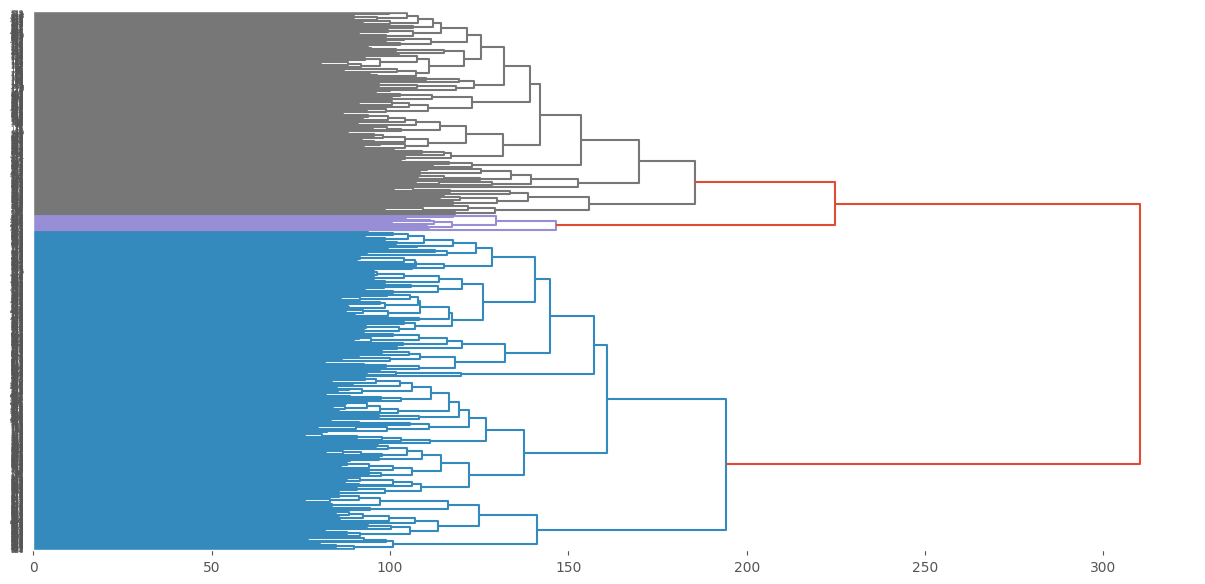

In [46]:
fig = plt.figure("0", figsize=(15,7))
L = linkage(dist, "complete")
dn=dendrogram(L, orientation='right')

type of b:  <class 'stablerank.barcodes.BC'>


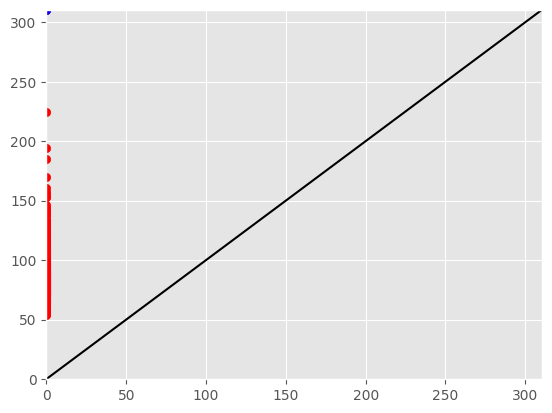

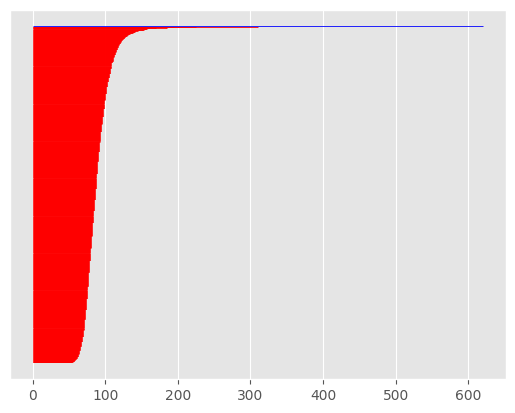

In [48]:
b = sr.linkage_to_bc(L)
print("type of b: ", type(b))
plt.figure("persitance diagram")
b.persistence_diagram()
plt.figure("bar code")
b.plot()

<class 'stablerank.rtorf.Pcnif'>


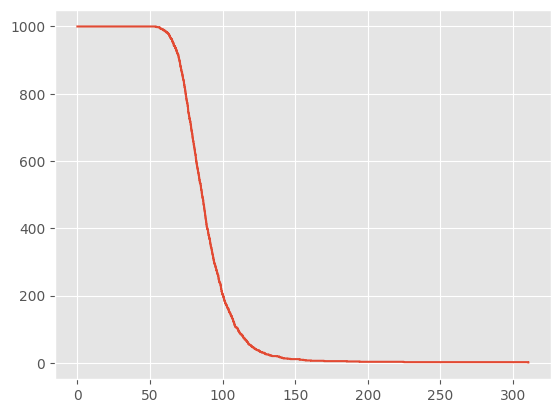

In [49]:
f = b.stable_rank()
print(type(f))
f.plot()

In [ ]:
d = sr.Distance(dist_sqrfrm)
b = d.get_bc(maxdim=2, coeff=2)
print("bc: ", b)
print("*"*10)

print("""b["H1"].bars: """)
print(b["H1"].bars)

plt.figure("bc_persistence_diagram")
plt.title("persistence_diagram")
b["H1"].persistence_diagram()

plt.figure("bc_bars")
plt.title("bars")
b["H1"].plot()

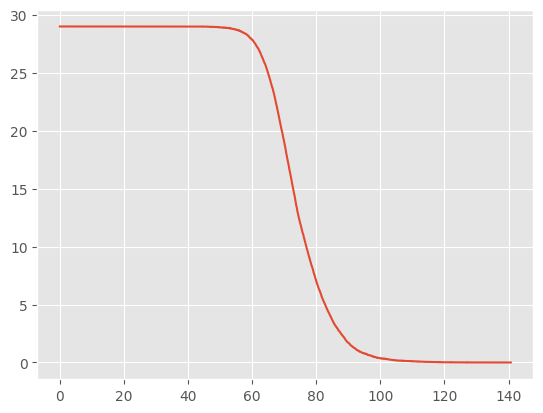

In [22]:
h0sr.plot()

In [4]:
def plot_sr(n_samples, linkage_method="complete"):
    """
    Randomly sample n_samples elements from A_unpacked and B_unpacked each (without replacement),
    compute their stable rank via complete linkage, and plot them overlaid with binary color coding.
    A: color 'blue', B: color 'red'
    """
    # Ensure there are enough samples in both
    nA_total = len(A_unpacked)
    nB_total = len(B_unpacked)
    assert n_samples <= nA_total and n_samples <= nB_total, "Not enough samples in either A or B."
    
    indices_A = rng.choice(nA_total, size=n_samples, replace=False)
    indices_B = rng.choice(nB_total, size=n_samples, replace=False)

    plt.figure(figsize=(10, 6))
    label_plotted = [False, False]  # For legend avoiding repeats

    for k, idx in enumerate(indices_A):
        data = A_unpacked[idx]
        dist = pdist(data, "euclidean")
        L = linkage(dist, linkage_method)
        b = sr.linkage_to_bc(L)
        f = b.stable_rank()
        if not label_plotted[0]:
            f.plot(color='blue', alpha=0.5, label="A")
            label_plotted[0] = True
        else:
            f.plot(color='blue', alpha=0.5)
        
    for k, idx in enumerate(indices_B):
        data = B_unpacked[idx]
        dist = pdist(data, "euclidean")
        L = linkage(dist, linkage_method)
        b = sr.linkage_to_bc(L)
        f = b.stable_rank()
        if not label_plotted[1]:
            f.plot(color='red', alpha=0.5, label="B")
            label_plotted[1] = True
        else:
            f.plot(color='red', alpha=0.5)
        
    plt.title(f'Stable Rank of {n_samples} Random Samples from Each Class')
    plt.xlabel('Filtration Value')
    plt.ylabel('Stable Rank')
    plt.legend()
    plt.show()


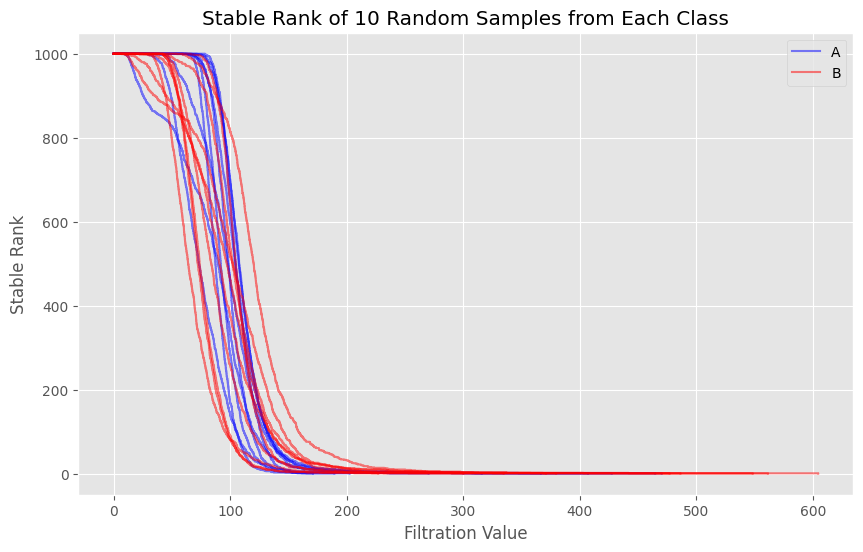

In [67]:
plot_sr(10, "complete")

# Building

In [14]:
from sklearn.model_selection import train_test_split

# Assuming data is your feature matrix and y is your labels/targets
X_train, X_test, y_train, y_test = train_test_split(
    data, y, test_size=0.25, random_state=42, stratify=y
)


with open("X_train.pkl", "wb") as f:
    pickle.dump(X_train, f)
with open("X_test.pkl", "wb") as f:
    pickle.dump(X_test, f)


In [23]:


def average_sr(point_cloud, number_instances, sample_size):
    """
    Compute the average stable rank of a point cloud over a range of sample sizes.
    
    Args:
        point_cloud: numpy array of shape (n_points, n_features)
        number_instances: number of random samples to take
    """
    d = sr.Distance(squareform(pdist(point_cloud, "euclidean")))
    s = sr.get_sample(number_instances, sample_size, probabilities=point_cloud.shape[0])
    b = d.get_bc(sample=s, maxdim=1)
    h0sr = sr.bc_to_sr(b, degree="H0")
    h1sr = sr.bc_to_sr(b, degree="H1")
    return h0sr, h1sr



def average_h0sr_linkage(point_cloud, linkage_method="complete"):
    """
    Compute the average stable rank of a point cloud over a range of sample sizes.
    
    Args:
        point_cloud: numpy array of shape (n_points, n_features)
    """
    dist = pdist(point_cloud, "euclidean")
    L = linkage(dist, linkage_method)
    b = sr.linkage_to_bc(L)
    f = b.stable_rank()
    return f



#h0sr, h1sr = average_sr(A_unpacked[0], 500, 30)

In [26]:

train_h0sr_complete = []
test_h0sr_complete = []
for i in range(len(X_train)):
    print(i)
    train_h0sr_complete.append(average_h0sr_linkage(X_train[i], "complete"))

for i in range(len(X_test)):
    print(i)
    test_h0sr_complete.append(average_h0sr_linkage(X_test[i], "complete"))



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [51]:
# with open("train_h0sr_complete.pkl", "wb") as f:
#     pickle.dump(train_h0sr_complete, f)
# with open("test_h0sr_complete.pkl", "wb") as f:
#     pickle.dump(test_h0sr_complete, f)

with open("train_h0sr_complete.pkl", "rb") as f:
    train_h0sr_complete = pickle.load(f)
with open("test_h0sr_complete.pkl", "rb") as f:
    test_h0sr_complete = pickle.load(f)


In [56]:
# h0_complete_kernel_train = np.asarray([[f.dot(g) for g in train_h0sr_complete] for f in train_h0sr_complete])
# h0_complete_kernel_test = np.asarray([[f.dot(g) for g in train_h0sr_complete] for f in test_h0sr_complete])

with open("train_h0sr_complete.pkl", "rb") as f:
    train_h0sr_complete = pickle.load(f)
with open("test_h0sr_complete.pkl", "rb") as f:
    test_h0sr_complete = pickle.load(f)

#Small trick to not integrate to inf
for i in range(len(train_h0sr_complete)):
    train_h0sr_complete[i].content[1] -= 1
    
for i in range(len(test_h0sr_complete)):
    test_h0sr_complete[i].content[1] -= 1

# pip install tqdm tqdm-joblib
import numpy as np
from joblib import Parallel, delayed
from tqdm.auto import tqdm
from tqdm_joblib import tqdm_joblib

def row_vs_list(f, G):
    return np.fromiter((f.dot(g) for g in G), dtype=float, count=len(G))

# --- train–train (symmetric: compute only j >= i) ---
n = len(train_h0sr_complete)
with tqdm_joblib(tqdm(total=n, desc="train kernel (rows)", unit="row")):
    rows = Parallel(n_jobs=-1, prefer="processes")(
        delayed(row_vs_list)(train_h0sr_complete[i], train_h0sr_complete[i:]) for i in range(n)
    )

h0_complete_kernel_train = np.empty((n, n), float)
for i, r in enumerate(rows):
    h0_complete_kernel_train[i, i:] = r
    h0_complete_kernel_train[i:, i] = r

# --- test–train ---
with tqdm_joblib(tqdm(total=len(test_h0sr_complete), desc="test kernel (rows)", unit="row")):
    test_rows = Parallel(n_jobs=-1, prefer="processes")(
        delayed(row_vs_list)(f, train_h0sr_complete) for f in test_h0sr_complete
    )
h0_complete_kernel_test = np.vstack(test_rows)


train kernel (rows):   0%|          | 0/1200 [00:00<?, ?row/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

test kernel (rows):   0%|          | 0/400 [00:00<?, ?row/s]

  0%|          | 0/400 [00:00<?, ?it/s]

In [ ]:
# with open("h0_complete_kernel_train.pkl", "wb") as f:
#     pickle.dump(h0_complete_kernel_train, f)
# with open("h0_complete_kernel_test.pkl", "wb") as f:
#     pickle.dump(h0_complete_kernel_test, f)


In [ ]:
with open("train_h0sr_complete.pkl", "rb") as f:
    train_h0sr_complete = pickle.load(f)
with open("test_h0sr_complete.pkl", "rb") as f:
    test_h0sr_complete = pickle.load(f)

#Small trick to not integrate to inf
for i in range(len(train_h0sr_complete)):
    train_h0sr_complete[i].content[1] -= 1
    
for i in range(len(test_h0sr_complete)):
    test_h0sr_complete[i].content[1] -= 1


np.float64(87374238.05415227)

In [23]:
train_h0sr = []
train_h1sr = []

number_instances = 500
sample_size = 30

for i in range(len(X_train)):
    print(i)
    h0sr, h1sr = average_sr(X_train[i], number_instances, sample_size)
    train_h0sr.append(h0sr)
    train_h1sr.append(h1sr)

test_h0sr = []
test_h1sr = []
for i in range(len(X_test)):
    print(i)
    h0sr, h1sr = average_sr(X_test[i], number_instances, sample_size)
    test_h0sr.append(h0sr)
    test_h1sr.append(h1sr)




0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
# import pickle
# with open("train_h0sr.pkl", "wb") as f:
#     pickle.dump(train_h0sr, f)
# with open("train_h1sr.pkl", "wb") as f:
#     pickle.dump(train_h1sr, f)
# with open("test_h0sr.pkl", "wb") as f:
#     pickle.dump(test_h0sr, f)
# with open("test_h1sr.pkl", "wb") as f:
#     pickle.dump(test_h1sr, f)




In [ ]:
# with open("train_y.pkl", "wb") as f:
#     pickle.dump(y_train, f)
# with open("test_y.pkl", "wb") as f:
#     pickle.dump(y_test, f)

In [ ]:
# with open("train_h0sr.pkl", "rb") as f:
#     train_h0sr = pickle.load(f)
# with open("train_h1sr.pkl", "rb") as f:
#     train_h1sr = pickle.load(f)
# with open("test_h0sr.pkl", "rb") as f:
#     test_h0sr = pickle.load(f)
# with open("test_h1sr.pkl", "rb") as f:
#     test_h1sr = pickle.load(f)

In [10]:
len(test_h0sr)

400

In [11]:
# pip install tqdm tqdm-joblib
import numpy as np
from joblib import Parallel, delayed
from tqdm.auto import tqdm
from tqdm_joblib import tqdm_joblib

def row_vs_list(f, G):
    return np.fromiter((f.dot(g) for g in G), dtype=float, count=len(G))

# --- train–train (symmetric: compute only j >= i) ---
n = len(train_h0sr)
with tqdm_joblib(tqdm(total=n, desc="train kernel (rows)", unit="row")):
    rows = Parallel(n_jobs=-1, prefer="processes")(
        delayed(row_vs_list)(train_h0sr[i], train_h0sr[i:]) for i in range(n)
    )

h0_kernel_train = np.empty((n, n), float)
for i, r in enumerate(rows):
    h0_kernel_train[i, i:] = r
    h0_kernel_train[i:, i] = r

# --- test–train ---
with tqdm_joblib(tqdm(total=len(test_h0sr), desc="test kernel (rows)", unit="row")):
    test_rows = Parallel(n_jobs=-1, prefer="processes")(
        delayed(row_vs_list)(f, train_h0sr) for f in test_h0sr
    )
h0_kernel_test = np.vstack(test_rows)

train kernel (rows):   0%|          | 0/1200 [00:00<?, ?row/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

test kernel (rows):   0%|          | 0/400 [00:00<?, ?row/s]

  0%|          | 0/400 [00:00<?, ?it/s]

In [ ]:
import pickle

# # Save train kernel
# with open("h0_kernel_train.pkl", "wb") as f:
#     pickle.dump(h0_kernel_train, f)

# # Save test kernel
# with open("h0_kernel_test.pkl", "wb") as f:
#     pickle.dump(h0_kernel_test, f)


In [19]:
# pip install tqdm tqdm-joblib
import numpy as np
from joblib import Parallel, delayed
from tqdm.auto import tqdm
from tqdm_joblib import tqdm_joblib

def row_vs_list(f, G):
    return np.fromiter((f.dot(g) for g in G), dtype=float, count=len(G))

# --- train–train (symmetric: compute only j >= i) ---
n = len(train_h1sr)
with tqdm_joblib(tqdm(total=n, desc="train kernel (rows)", unit="row")):
    rows = Parallel(n_jobs=-1, prefer="processes")(
        delayed(row_vs_list)(train_h1sr[i], train_h1sr[i:]) for i in range(n)
    )

h1_kernel_train = np.empty((n, n), float)
for i, r in enumerate(rows):
    h1_kernel_train[i, i:] = r
    h1_kernel_train[i:, i] = r

# --- test–train ---
with tqdm_joblib(tqdm(total=len(test_h1sr), desc="test kernel (rows)", unit="row")):
    test_rows = Parallel(n_jobs=-1, prefer="processes")(
        delayed(row_vs_list)(f, train_h1sr) for f in test_h1sr
    )
h1_kernel_test = np.vstack(test_rows)

train kernel (rows):   0%|          | 0/1200 [00:00<?, ?row/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

test kernel (rows):   0%|          | 0/400 [00:00<?, ?row/s]

  0%|          | 0/400 [00:00<?, ?it/s]

In [ ]:
# # Save train kernel
# with open("h1_kernel_train.pkl", "wb") as f:
#     pickle.dump(h1_kernel_train, f)

# # Save test kernel
# with open("h1_kernel_test.pkl", "wb") as f:
#     pickle.dump(h1_kernel_test, f)

In [13]:
# h0_kernel_train = np.asarray([[f.dot(g) for g in train_h0sr] for f in train_h0sr])
# h0_kernel_test = np.asarray([[f.dot(g) for g in train_h0sr] for f in test_h0sr])

# h1_kernel_train = np.asarray([[f.dot(g) for g in train_h1sr] for f in train_h1sr])
# h1_kernel_test = np.asarray([[f.dot(g) for g in train_h1sr] for f in test_h1sr])

In [22]:
print(h0_kernel_train.shape)
print(h0_kernel_test.shape)
print(h1_kernel_train.shape)
print(h1_kernel_test.shape)


(1200, 1200)
(400, 1200)
(1200, 1200)
(400, 1200)


In [ ]:
# import time

# num_runs = 100
# times = []
# for _ in range(num_runs):
#     a = train_h0sr[0]
#     b = train_h0sr[1]
#     start = time.time()
#     _ = a.dot(b)
#     end = time.time()
#     times.append(end - start)

# avg_time = sum(times) / num_runs
# print(f"Average time over {num_runs} runs: {avg_time:.6f} seconds")

# a.dot(b)

Average time over 100 runs: 0.003061 seconds


np.float64(81876.90080135489)

In [3]:
# with open("train_h0sr.pkl", "rb") as f:
#     train_h0sr = pickle.load(f)
# with open("train_h1sr.pkl", "rb") as f:
#     train_h1sr = pickle.load(f)
# with open("test_h0sr.pkl", "rb") as f:
#     test_h0sr = pickle.load(f)
# with open("test_h1sr.pkl", "rb") as f:
#     test_h1sr = pickle.load(f)

with open("h0_kernel_train.pkl", "rb") as f:
    h0_kernel_train = pickle.load(f)
with open("h0_kernel_test.pkl", "rb") as f:
    h0_kernel_test = pickle.load(f)
with open("h1_kernel_train.pkl", "rb") as f:
    h1_kernel_train = pickle.load(f)
with open("h1_kernel_test.pkl", "rb") as f:
    h1_kernel_test = pickle.load(f)
with open("h0_complete_kernel_train.pkl", "rb") as f:
    h0_complete_kernel_train = pickle.load(f)
with open("h0_complete_kernel_test.pkl", "rb") as f:
    h0_complete_kernel_test = pickle.load(f)
with open("train_y.pkl", "rb") as f:
    y_train = pickle.load(f)
with open("test_y.pkl", "rb") as f:
    y_test = pickle.load(f)
with open("train_h0sr_complete.pkl", "rb") as f:
    train_h0sr_complete = pickle.load(f)
with open("test_h0sr_complete.pkl", "rb") as f:
    test_h0sr_complete = pickle.load(f)


In [7]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Fit SVC on the precomputed train kernel
svc = SVC(kernel='precomputed')
svc.fit(h0_complete_kernel_train / 10000, y_train)

# Predict using the precomputed test kernel
y_pred = svc.predict(h0_complete_kernel_test / 10000)

# Classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.77      0.81      0.79       200
           1       0.80      0.76      0.78       200

    accuracy                           0.79       400
   macro avg       0.79      0.79      0.78       400
weighted avg       0.79      0.79      0.78       400



In [10]:
h_combined_kernel = h0_kernel_train + h1_kernel_train + h0_complete_kernel_train / 10000
h_combined_test = h0_kernel_test + h1_kernel_test + h0_complete_kernel_test / 10000

svc.fit(h_combined_kernel, y_train)
y_pred = svc.predict(h_combined_test)
print(classification_report(y_test, y_pred))

# np.min(h0_kernel_train)


              precision    recall  f1-score   support

           0       0.81      0.79      0.80       200
           1       0.79      0.81      0.80       200

    accuracy                           0.80       400
   macro avg       0.80      0.80      0.80       400
weighted avg       0.80      0.80      0.80       400



In [12]:
h1_kernel_train

array([[ 97.5505,  47.4432,  84.9303, ...,  99.2603,  78.9288, 100.866 ],
       [ 47.4432,  25.0233,  42.2451, ...,  48.3452,  37.215 ,  48.4126],
       [ 84.9303,  42.2451,  74.9463, ...,  86.5827,  66.8748,  86.9402],
       ...,
       [ 99.2603,  48.3452,  86.5827, ..., 101.0506,  79.9395, 102.4704],
       [ 78.9288,  37.215 ,  66.8748, ...,  79.9395,  68.0268,  83.4869],
       [100.866 ,  48.4126,  86.9402, ..., 102.4704,  83.4869, 105.1606]])

In [31]:
from sklearn.pipeline import Pipeline

def custom_kernel(fs, gs):
    return np.asarray([[f.dot(g) for f in fs] for g in gs])

pipe = Pipeline([
    ('clf', SVC(kernel=custom_kernel))
])

param_grid = {
    'clf__C': [0.1, 0.5, 1, 5, 10]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(pipe, param_grid, cv=cv, scoring='accuracy', verbose=10)
gs.fit(h0s_train, y_train)

print("Best params:", gs.best_params_)
print("CV best f1_score:", gs.best_score_)
from sklearn.metrics import classification_report

y_pred = gs.predict(h0s_test)
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START clf__C=0.1..................................................


KeyboardInterrupt: 